# Data preprocessor

In [178]:
import os
import glob
import cv2
import pandas as pd

from os import mkdir

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

output_dir = '../data/hnet_training'
try: 
    mkdir('../data/hnet_training')
except FileExistsError:
    print('directory already exists')

data_dir = r'../data'
original_data_dir = data_dir + ('/learning')
all_files = load_img_paths(original_data_dir)
all_files[:5]

['../data/learning\\Tp26_Y000_X000_040.tif',
 '../data/learning\\Tp26_Y000_X001_040.tif',
 '../data/learning\\Tp26_Y000_X002_040.tif',
 '../data/learning\\Tp26_Y000_X003_040.tif',
 '../data/learning\\Tp26_Y000_X004_040.tif']

In [176]:
import numpy as np
from numpy.random import randint

def aspect_resize(newsize, shape):
    '''
    Given an integer and a shape, return a tuple with the longest side of the shape = newsize
    '''
    m = np.argmax(shape)
    if m == 0:
        return (newsize, int(shape[1] / (shape[0] / newsize)))
    return (int(shape[0] / (shape[1] / newsize)), newsize)

def alter_pt(pt, r):
    return (pt[0] + randint(-r,r), pt[1] + randint(-r,r))

def create_patches(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points
        x = randint(0, im.shape[1]-size)
        y = randint(0, im.shape[0]-size)
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        tl2 = alter_pt(tl, r)
        tr2 = alter_pt(tr, r)
        br2 = alter_pt(br, r)
        bl2 = alter_pt(bl, r)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpPerspective(im, Hab, im.shape)
        B = full_warped[y:y+size,x:x+size]
        if A.shape == B.shape:
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])


[[ 26.  25.]
 [ 12.   9.]
 [ 16.  16.]
 [-13.  18.]]


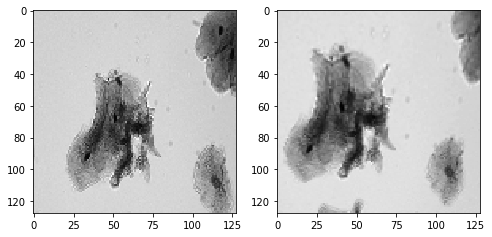

In [177]:
from matplotlib import pyplot as plt

im = cv2.imread(all_files[0], cv2.IMREAD_UNCHANGED)
im = cv2.resize(im, aspect_resize(320, im.shape))
a,b,h = create_patches(im, patch_size, rho)

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
mov.imshow(b, cmap='gray')
plt.show()

## Generate patches

- `new_size` - recommended that it be small enough so that there is content in the image 320 is what the paper uses. 
- `patch_size` - size of patch, here it's 128, so that horizontally if covers about a third of the image.
- `rho` - we can think of this as overlap, it's the theshold on perturbation in the transform.
- `patches_per_image` - size of inner loop, should probably be greater than 100

In [179]:
df = pd.DataFrame(columns=['fname', 'h'])
new_size = 320
patch_size = 128
rho = 32

'''
we have 8*15 = 120 images right now...
100 = 12,00
500 = 60,000
750 = 90,000
1000 = 120,000
'''

patches_per_image = 500

for f in all_files:
    fname,ext = os.path.basename(f).split('.')
    for p in range(0, patches_per_image):
        im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        im = cv2.resize(im, aspect_resize(new_size, im.shape))
        A,B,Hab = create_patches(im, patch_size, rho)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), A)
        cv2.imwrite(os.path.join(output_dir, B_name), B)
        hab_1d = ','.join(list(map(lambda x: str(int(x)), Hab.reshape(1,8)[0].tolist())))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

In [182]:
df.head()

,fname,h
0,Tp26_Y000_X000_040_0000,"-27,-16,-15,-5,-30,-25,-4,26"
1,Tp26_Y000_X000_040_0001,"0,-24,-8,7,-26,18,-13,-6"
2,Tp26_Y000_X000_040_0002,"-18,-2,21,-8,13,26,25,4"
3,Tp26_Y000_X000_040_0003,"25,-9,-30,-5,-6,18,-19,-6"
4,Tp26_Y000_X000_040_0004,"-8,4,-10,9,-13,2,-32,-23"


In [183]:
len(df)

60000